In [12]:
from sklearn.datasets import load_iris, load_diabetes
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.neighbors import KNeighborsClassifier

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [14]:
from numpy.typing import ArrayLike
from typing import Union
from collections import Counter


class KNearestNeighbors:
    """
    Custom implementation of the k-Nearest Neighbors (KNN) algorithm.

    Supports both classification and regression tasks.

    Parameters
    ----------
    n_neighbors : int, default=3
        Number of neighbors to consider.
    regression : bool, default=False
        If True, performs regression (returns average of neighbors).
        If False, performs classification (returns most common label).
    """

    def __init__(self, n_neighbors: int = 3, regression: bool = False):
        if n_neighbors < 1:
            raise ValueError("n_neighbors must be >= 1")
        self.n_neighbors = n_neighbors
        self.regression = regression
        self._is_fitted = False

    def fit(self, X_train: ArrayLike, y_train: ArrayLike) -> None:
        """
        Store the training data.

        Parameters
        ----------
        X_train : array-like of shape (n_samples, n_features)
            Training feature matrix.
        y_train : array-like of shape (n_samples,)
            Target values.
        """
        X_train = np.array(X_train)
        y_train = np.array(y_train)

        if len(X_train) != len(y_train):
            raise ValueError("X_train and y_train must have the same length")
        if self.n_neighbors > len(X_train):
            raise ValueError("n_neighbors cannot be greater than number of samples")

        self.X_train = X_train
        self.y_train = y_train
        self._is_fitted = True

    def _euclidean_distance(self, X_test_i: np.ndarray) -> np.ndarray:
        """Compute Euclidean distance between one test sample and all training samples."""
        return np.sqrt(np.sum((self.X_train - X_test_i) ** 2, axis=1))

    def _make_prediction(self, X_test_i: np.ndarray) -> Union[int, float, str]:
        """Predict the target for a single sample."""
        distances = self._euclidean_distance(X_test_i)
        k_nearest_indexes = np.argsort(distances)[:self.n_neighbors]
        targets = self.y_train[k_nearest_indexes]

        if self.regression:
            return float(np.mean(targets))
        else:
            return Counter(targets).most_common(1)[0][0]

    def predict(self, X_test: ArrayLike) -> np.ndarray:
        """
        Predict the target for each sample in X_test.

        Parameters
        ----------
        X_test : array-like of shape (n_samples, n_features)

        Returns
        -------
        np.ndarray of shape (n_samples,)
            Predictions.
        """
        if not self._is_fitted:
            raise ValueError("The model has not been fitted yet. Call 'fit' first.")

        X_test = np.array(X_test)
        return np.array([self._make_prediction(x) for x in X_test])


### Тестируем наш классификатор на известном датасете Iris

In [15]:
X, y = load_iris(return_X_y=True, as_frame=True)

In [16]:
X.head()

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm)
0,5.1,3.5,1.4,0.2
1,4.9,3.0,1.4,0.2
2,4.7,3.2,1.3,0.2
3,4.6,3.1,1.5,0.2
4,5.0,3.6,1.4,0.2


In [17]:
X_train, X_test, y_train, y_test = train_test_split(X.values, y.values, test_size=0.33, random_state=11)

knn_clf = KNearestNeighbors(n_neighbors=5, regression=False)

knn_clf.fit(X_train, y_train)

pred = knn_clf.predict(X_test)

print(f'Accuracy socre: {accuracy_score(y_test, pred)}')

Accuracy socre: 0.98


In [18]:
# Сравнение с sklearn
sk_knn = KNeighborsClassifier(n_neighbors=5)
sk_knn.fit(X_train, y_train)
y_pred_sklearn = sk_knn.predict(X_test)
print("Sklearn KNN Accuracy (Iris):", accuracy_score(y_test, y_pred_sklearn))

Sklearn KNN Accuracy (Iris): 0.98


### Небольшая визуализация

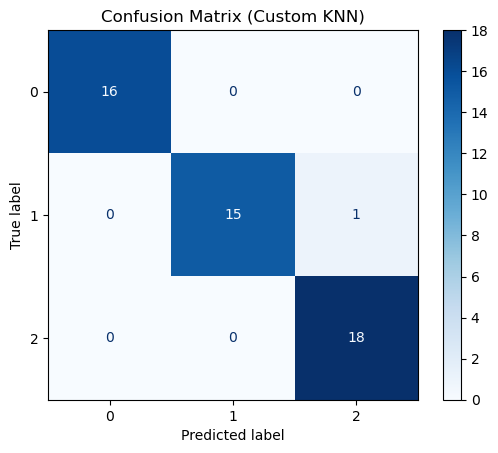

In [19]:
from sklearn.metrics import ConfusionMatrixDisplay

ConfusionMatrixDisplay.from_predictions(y_test, pred, cmap='Blues')
plt.title("Confusion Matrix (Custom KNN)")
plt.show()

### Теперь протестируем наш "KnnRegressor" на датасете Diabets из библиотеки sklearn

In [20]:
from sklearn.datasets import load_diabetes
from sklearn.metrics import r2_score

X2, y2 = load_diabetes(return_X_y=True, as_frame=True)

X2_train, X2_test, y2_train, y2_test = train_test_split(X2.values, y2.values, test_size=0.33, random_state=3)

knn_reg = KNearestNeighbors(n_neighbors=5, regression=True)
knn_reg.fit(X2_train, y2_train)
pred_reg = knn_reg.predict(X2_test)

print(f'R^2 score: {r2_score(y2_test, pred_reg)}')

R^2 score: 0.2960803415209895


#### Явно нелучший результат, в будущем можно доработать добавив собственную кросс-валидацию. Или доработать свой класс до стандарта sklearn

In [22]:
# Сравнение с sklearn
from sklearn.neighbors import KNeighborsRegressor

sk_knn_reg = KNeighborsRegressor(n_neighbors=5)
sk_knn_reg.fit(X2_train, y2_train)
y_pred_sklearn_reg = sk_knn_reg.predict(X2_test)
print("Sklearn KNN R2-Score (Diabetes):", r2_score(y2_test, y_pred_sklearn_reg))

Sklearn KNN R2-Score (Diabetes): 0.2960803415209895


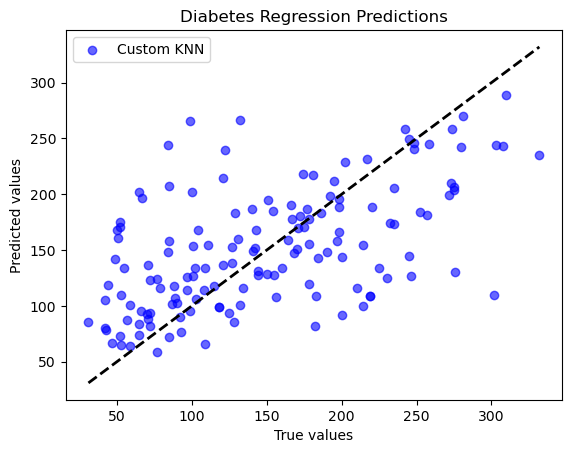

In [23]:
plt.scatter(y2_test, pred_reg, color='blue', alpha=0.6, label='Custom KNN')
plt.plot([y2_test.min(), y2_test.max()], [y2_test.min(), y2_test.max()], 'k--', lw=2)
plt.xlabel("True values")
plt.ylabel("Predicted values")
plt.title("Diabetes Regression Predictions")
plt.legend()
plt.show()